# Variational Auto Encoder

Este modelo se entrenará sobre un conjunto de 7k imágenes. Nos servirá como estructura inicial para el conditional variational autoencoder.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import cv2
import h5py
import matplotlib.pyplot as plt

# Data

In [8]:
with h5py.File("data/data_128_7k.h5", "r") as f:
    imgs = np.array(f["imgs"])
    labels = np.array(f["labels"])

In [9]:
shape_img = imgs.shape[1:]
latent_dim = 256

# Model

In [10]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    activation = LeakyReLU(0.3),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

def conv_block_transpose(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    activation = LeakyReLU(0.3),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3):
    x = Conv2DTranspose(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

# Encoder

In [11]:
enc_input_image = Input(shape=(shape_img), name="input_image")

# convolutionals block
enc_conv = conv_block(enc_input_image, filters=64, use_bn=True) # 128x128x64
enc_conv = conv_block(enc_conv, filters=64, strides=(2,2), use_dropout=True) # 64x64x64

enc_conv = conv_block(enc_conv, filters=128) # 64x64x128
enc_conv = conv_block(enc_conv, filters=128, strides=(2,2), use_bn=True, use_dropout=True) # 32x32x128

enc_conv = conv_block(enc_conv, filters=256, use_bn=True, use_dropout=True) # 32x32x256
enc_conv = conv_block(enc_conv, filters=256, use_bn=True, use_dropout=True) # 32x32x256
enc_conv = conv_block(enc_conv, filters=256, use_bn=True, use_dropout=True) # 32x32x256
enc_conv = conv_block(enc_conv, filters=256, strides=(2,2), use_bn=True, use_dropout=True) # 16x16x256

enc_conv = conv_block(enc_conv, filters=512, use_bn=True, use_dropout=True) # 16x16x512
enc_conv = conv_block(enc_conv, filters=512, use_bn=True, use_dropout=True) # 16x16x512
enc_conv = conv_block(enc_conv, filters=512, use_bn=True, use_dropout=True) # 16x16x512
enc_conv = conv_block(enc_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True) # 8x8x512

enc_conv = conv_block(enc_conv, filters=512) # 8x8x512
enc_conv = conv_block(enc_conv, filters=512, use_dropout=True) # 8x8x512
enc_conv = conv_block(enc_conv, filters=512) # 8x8x512
enc_conv = conv_block(enc_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True) # 4x4x512


# concat
flattened = Flatten()(enc_conv)

enc_hidden = Dense(4096)(flattened)
enc_hidden = Dropout(0.5)(enc_hidden)
enc_hidden = Dense(2048)(enc_hidden)
enc_hidden = Dropout(0.3)(enc_hidden)
enc_hidden = Dense(1024)(enc_hidden)
z_mean = Dense(latent_dim, activation='linear', name="mu")(enc_hidden)
z_log_var = Dense(latent_dim, activation='linear', name="l_sigma")(enc_hidden)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs=[enc_input_image], outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

2023-07-26 13:07:10.467475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 13:07:10.471054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 13:07:10.471190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_image[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)   multiple                     0         ['batch_normalization[0]

 chNormalization)                                                                                 
                                                                                                  
 dropout_7 (Dropout)         (None, 16, 16, 512)          0         ['leaky_re_lu_2[9][0]']       
                                                                                                  
 conv2d_10 (Conv2D)          (None, 16, 16, 512)          2359808   ['dropout_7[0][0]']           
                                                                                                  
 batch_normalization_8 (Bat  (None, 16, 16, 512)          2048      ['conv2d_10[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 dropout_8 (Dropout)         (None, 16, 16, 512)          0         ['leaky_re_lu_2[10][0]']      
          

# Decoder

In [6]:
dec_inp_latent_vector = Input(shape=(latent_dim), name="input_latent_vector")

dec_hidden = Dense(1024, activation="relu")(dec_inp_latent_vector)
dec_hidden = Dropout(0.3)(dec_hidden)
dec_hidden = Dense(2048, activation="relu")(dec_hidden)
dec_hidden = Dropout(0.3)(dec_hidden)
dec_hidden = Dense(4096, activation="relu")(dec_hidden)
dec_hidden = Dense(4*4*512, activation="relu", name="hidden_layer7")(dec_hidden)
dec_hidden = Dropout(0.3)(dec_hidden)
reshaped = Reshape(target_shape=(4,4,512))(dec_hidden)

dec_conv = conv_block_transpose(reshaped, filters=512, use_bn=True, use_dropout=True)  # 4x4x512
dec_conv = conv_block_transpose(dec_conv, filters=512)  # 4x4x512
dec_conv = conv_block_transpose(dec_conv, filters=512, use_dropout=True)  # 4x4x512
dec_conv = conv_block_transpose(dec_conv, filters=512, strides=(2,2), use_bn=True)  # 8x8x512

dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True)  # 8x8x512
dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True, use_dropout=True)  # 8x8x512
dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True)  # 8x8x512
dec_conv = conv_block_transpose(dec_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True)  # 16x16x512

dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True)  # 16x16x256
dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True, use_dropout=True)  # 16x16x256
dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True)  # 16x16x256
dec_conv = conv_block_transpose(dec_conv, filters=256, strides=(2,2), use_bn=True, use_dropout=True)  # 32x32x256

dec_conv = conv_block_transpose(dec_conv, filters=128, use_bn=True, use_dropout=True)  # 32x32x128
dec_conv = conv_block_transpose(dec_conv, filters=128, strides=(2,2), use_bn=True)  # 64x64x128

dec_conv = conv_block_transpose(dec_conv, filters=64, use_bn=True, use_dropout=True)  # 64x64x64
dec_conv = conv_block_transpose(dec_conv, filters=128, strides=(2,2), use_bn=True)  # 128x128x64

dec_output_img = Conv2DTranspose(filters=1, kernel_size=3, padding="same", activation="sigmoid")(dec_conv)


decoder = keras.Model(inputs=dec_inp_latent_vector, outputs=dec_output_img, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_latent_vector (Input  [(None, 256)]                0         []                            
 Layer)                                                                                           
                                                                                                  
 dense_3 (Dense)             (None, 1024)                 263168    ['input_latent_vector[0][0]'] 
                                                                                                  
 dropout_10 (Dropout)        (None, 1024)                 0         ['dense_3[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 2048)                 2099200   ['dropout_10[0][0]']    

 chNormalization)                                                                                 
                                                                                                  
 dropout_15 (Dropout)        (None, 8, 8, 512)            0         ['leaky_re_lu_1[5][0]']       
                                                                                                  
 conv2d_transpose_6 (Conv2D  (None, 8, 8, 512)            2359808   ['dropout_15[0][0]']          
 Transpose)                                                                                       
                                                                                                  
 batch_normalization_10 (Ba  (None, 8, 8, 512)            2048      ['conv2d_transpose_6[0][0]']  
 tchNormalization)                                                                                
                                                                                                  
 conv2d_tr

# Variational AutoEncoder

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        imgs = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(imgs)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(imgs, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, input_image):
        _, _, z = self.encoder(input_image)
        return self.decoder(z)

In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))

In [9]:
imgs_train, imgs_val, labels_train, labels_val = train_test_split(imgs, labels, shuffle=True, test_size=0.15)

In [43]:
checkpoint = ModelCheckpoint(filepath="models/vae_weights/best_model_400+.h5",
                             save_weights_only=True,
                             monitor='loss',
                             mode='min',
                            save_best_only=True)

history = vae.fit(imgs, epochs=200, batch_size=64, callbacks=[checkpoint])

Epoch 1/200
110/110 [==============================] - 17s 157ms/step - loss: 5727.8777 - reconstruction_loss: 5719.8643 - kl_loss: 23.5353
Epoch 2/200
110/110 [==============================] - 17s 158ms/step - loss: 5744.8404 - reconstruction_loss: 5715.0610 - kl_loss: 23.4402
Epoch 3/200
110/110 [==============================] - 17s 156ms/step - loss: 5793.5725 - reconstruction_loss: 5786.2061 - kl_loss: 25.1011
Epoch 4/200
110/110 [==============================] - 17s 159ms/step - loss: 5860.0040 - reconstruction_loss: 5788.3901 - kl_loss: 25.8066
Epoch 5/200
110/110 [==============================] - 17s 156ms/step - loss: 5726.8353 - reconstruction_loss: 5725.5337 - kl_loss: 24.2902
Epoch 6/200
110/110 [==============================] - 18s 162ms/step - loss: 5753.7926 - reconstruction_loss: 5709.9448 - kl_loss: 23.6091
Epoch 7/200
110/110 [==============================] - 18s 162ms/step - loss: 5760.4975 - reconstruction_loss: 5704.1670 - kl_loss: 23.3492
Epoch 8/200
110/110 

110/110 [==============================] - 17s 158ms/step - loss: 5713.8910 - reconstruction_loss: 5709.4956 - kl_loss: 23.2704
Epoch 60/200
110/110 [==============================] - 17s 155ms/step - loss: 5694.8268 - reconstruction_loss: 5705.1421 - kl_loss: 23.0924
Epoch 61/200
110/110 [==============================] - 18s 162ms/step - loss: 5724.1577 - reconstruction_loss: 5703.0708 - kl_loss: 23.1074
Epoch 62/200
110/110 [==============================] - 18s 163ms/step - loss: 5747.7605 - reconstruction_loss: 5702.3521 - kl_loss: 23.0694
Epoch 63/200
110/110 [==============================] - 18s 161ms/step - loss: 5682.8903 - reconstruction_loss: 5701.5986 - kl_loss: 22.8651
Epoch 64/200
110/110 [==============================] - 18s 163ms/step - loss: 5745.5368 - reconstruction_loss: 5701.2295 - kl_loss: 22.9264
Epoch 65/200
110/110 [==============================] - 17s 156ms/step - loss: 5740.9963 - reconstruction_loss: 5701.2266 - kl_loss: 22.9916
Epoch 66/200
110/110 [====

110/110 [==============================] - 17s 156ms/step - loss: 5694.9245 - reconstruction_loss: 5693.8452 - kl_loss: 22.6975
Epoch 118/200
110/110 [==============================] - 17s 155ms/step - loss: 5731.3298 - reconstruction_loss: 5692.1108 - kl_loss: 22.6057
Epoch 119/200
110/110 [==============================] - 17s 156ms/step - loss: 5692.3334 - reconstruction_loss: 5695.4102 - kl_loss: 22.6467
Epoch 120/200
110/110 [==============================] - 17s 155ms/step - loss: 5699.0843 - reconstruction_loss: 5694.3359 - kl_loss: 22.6035
Epoch 121/200
110/110 [==============================] - 17s 157ms/step - loss: 5701.5683 - reconstruction_loss: 5696.3647 - kl_loss: 22.8154
Epoch 122/200
110/110 [==============================] - 17s 158ms/step - loss: 5695.9526 - reconstruction_loss: 5701.5586 - kl_loss: 22.8739
Epoch 123/200
110/110 [==============================] - 17s 155ms/step - loss: 5700.5980 - reconstruction_loss: 5697.0464 - kl_loss: 22.6493
Epoch 124/200
110/11

110/110 [==============================] - 17s 156ms/step - loss: 5695.0087 - reconstruction_loss: 5677.5869 - kl_loss: 21.9811
Epoch 175/200
110/110 [==============================] - 17s 157ms/step - loss: 5708.7513 - reconstruction_loss: 5677.2861 - kl_loss: 22.0750
Epoch 176/200
110/110 [==============================] - 17s 159ms/step - loss: 5685.6858 - reconstruction_loss: 5677.5947 - kl_loss: 22.0436
Epoch 177/200
110/110 [==============================] - 17s 156ms/step - loss: 5703.9920 - reconstruction_loss: 5680.4448 - kl_loss: 22.0164
Epoch 178/200
110/110 [==============================] - 17s 159ms/step - loss: 5704.8298 - reconstruction_loss: 5679.7686 - kl_loss: 21.9951
Epoch 179/200
110/110 [==============================] - 17s 156ms/step - loss: 5683.7595 - reconstruction_loss: 5679.8799 - kl_loss: 22.0445
Epoch 180/200
110/110 [==============================] - 17s 156ms/step - loss: 5687.7287 - reconstruction_loss: 5680.7046 - kl_loss: 22.0467
Epoch 181/200
110/11

In [44]:
history_list += history.history["loss"]

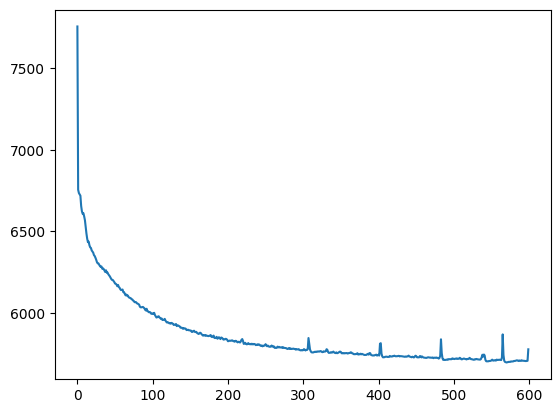

In [45]:
plt.plot(history_list)

In [46]:
img_test = imgs[300:301]

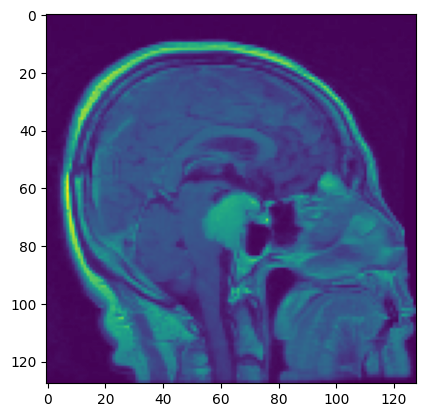

In [47]:
plt.imshow(img_test[0])

1/1 [==============================] - 0s 10ms/step


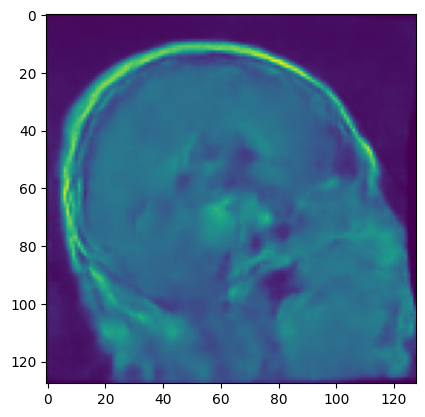

In [48]:
plt.imshow(vae.predict(img_test)[0])

1/1 [==============================] - 0s 10ms/step


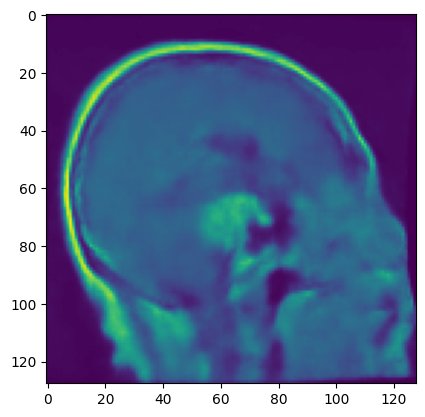

In [38]:
plt.imshow(vae.predict(img_test)[0])